# a04 Example - Optimization Scan Using Gradient Descent via Finite Difference Gradient Estimation

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from functools import partial

## Setup devices

In [2]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define measure function

In [3]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

## Define live plot

In [4]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

## Define runinfo

In [5]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

## Define control function for optimization experiment

In [6]:
def finite_difference_optimizer(sample_f, input_init, input_delta, output_epsilon, iteration_max=100):

    def finite_difference(f, f_in, f_out, input_delta, dim, i):
        f_in_dim_plus = f_in.copy()
        f_in_dim_plus[dim] = f_in[dim] + input_delta[dim]
        f_out_plus = f(f_in_dim_plus)[0]
        i += 1 # measured
        f_out_delta_plus = f_out_plus - f_out
        if f_out_delta_plus < 0:
            return f_in_dim_plus, f_out_plus, f_out_delta_plus, i
        else:
            f_in_dim_minus = f_in.copy()
            f_in_dim_minus[dim] = f_in[dim] - input_delta[dim]
            f_out_minus = f(f_in_dim_minus)[0]
            i += 1 # measured
            f_out_delta_minus = f_out_minus - f_out
            return f_in_dim_minus, f_out_minus, f_out_delta_minus, i

    dim_ct = len(input_init)
    keep_running = np.full(dim_ct, True)
    f_in_i = input_init
    f_out_i = sample_f(f_in_i)[0] # 1 dim output only
    dim = 0
    i = 1
    while i < iteration_max - 1: # could measure twice in a loop iter
        f_in_i, f_out_i, f_out_delta, i = finite_difference(sample_f, f_in_i, f_out_i, input_delta, dim, i)
        keep_running[dim] = abs(f_out_delta) > output_epsilon[dim]
        if not keep_running.any():
            break
        dim += 1
        dim %= dim_ct

In [7]:
control_f = partial(finite_difference_optimizer, input_init=np.array([2., 1.]), input_delta=np.array([.2, .3]), output_epsilon=np.array([.1, .2]), iteration_max=100)

## Define scan

In [8]:
runinfo.scan0 = ps.OptimizeFunctionalScan(('v1', 'v2'), 'voltage', 100,
                                          dt=1.)


## Define and run experiments

In [9]:
expt = ps.OptimizeFunctionalExperiment(runinfo, devices, control_f, ('vf',), 'voltage',
                                       time=True)
expt.start_thread()

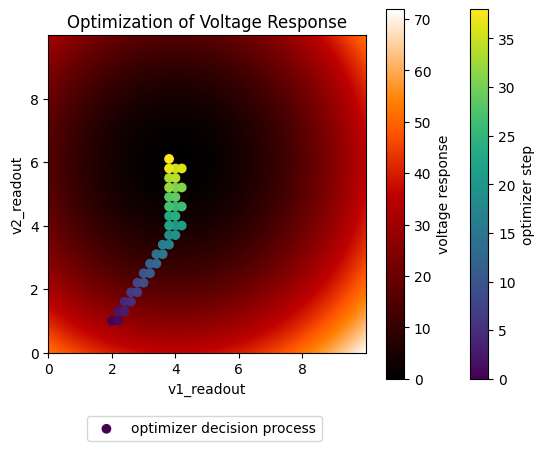

In [10]:
fig, ax = plt.subplots()
cb0 = cb1 = None
try:
    plot_optim_live(expt)
except KeyboardInterrupt:
    expt.stop()

In [11]:
# sleep(1) # wait for thread to finish

In [12]:
expt.__dict__

{'runinfo': <pyscan.measurement.run_info.RunInfo at 0x2211371fa10>,
 'devices': <pyscan.general.item_attribute.ItemAttribute at 0x2211371f620>,
 'control_f': functools.partial(<function finite_difference_optimizer at 0x000002211385F240>, input_init=array([2., 1.]), input_delta=array([0.2, 0.3]), output_epsilon=array([0.1, 0.2]), iteration_max=100),
 'sample_f_outputs': ('vf',),
 'prop': 'voltage',
 'expt_thread': <Thread(Thread-3 (run), stopped daemon 7392)>,
 'v1_voltage': array([2. , 2.2, 2.2, 2.4, 2.4, 2.6, 2.6, 2.8, 2.8, 3. , 3. , 3.2, 3.2,
        3.4, 3.4, 3.6, 3.6, 3.8, 3.8, 4. , 4. , 4.2, 3.8, 3.8, 4. , 4. ,
        4.2, 3.8, 3.8, 4. , 4. , 4.2, 3.8, 3.8, 4. , 4. , 4.2, 3.8, 3.8,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. 

In [13]:
# ps.live_plot2D(expt, data_name="vf") # TODO: remove empty values from v1_voltage and v2_voltage

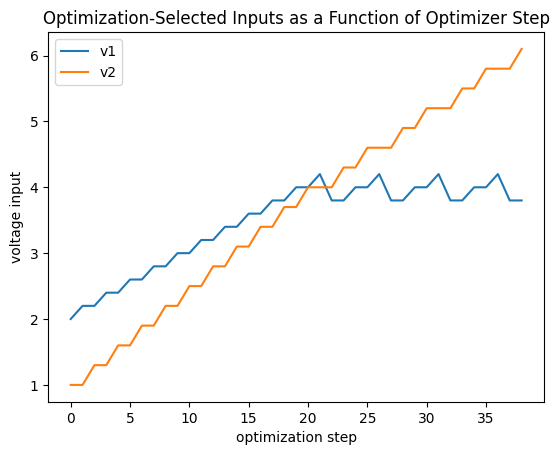

In [14]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

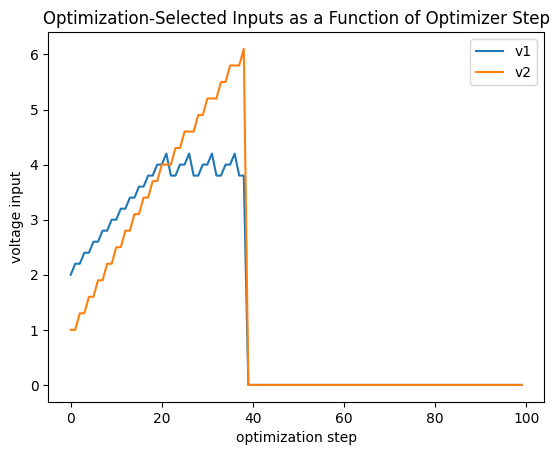

In [15]:
plt.plot(list(zip(expt.v1_voltage, expt.v2_voltage))) # TODO: trim unused inputs from scan dict?
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

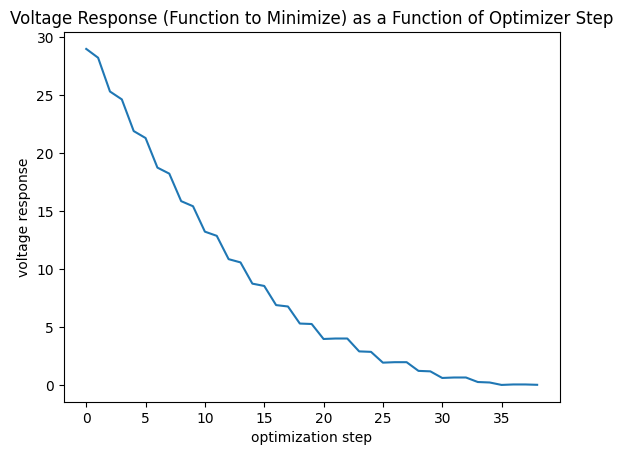

In [16]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

In [17]:
def plot_optim_pcm():
    fig, ax = plt.subplots()
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                         cmap='viridis')
    ax.set_box_aspect(1)
    fig.colorbar(scatter, label="optimizer step")
    fig.colorbar(pcm, label="voltage response")
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

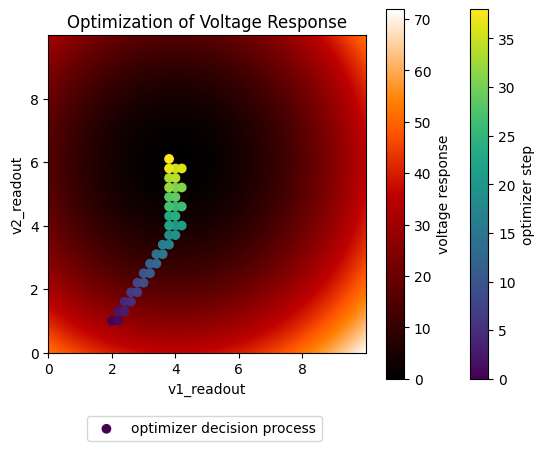

In [18]:
plot_optim_pcm()

In [19]:
def plot_optim_3d(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, expt.vf, c=range(len(expt.v1_readout)))
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step", pad=.1)
    ax.legend(["voltage response function", "optimizer decision process",], loc='lower left', bbox_to_anchor=(.2, -.2))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimization of Voltage Response")

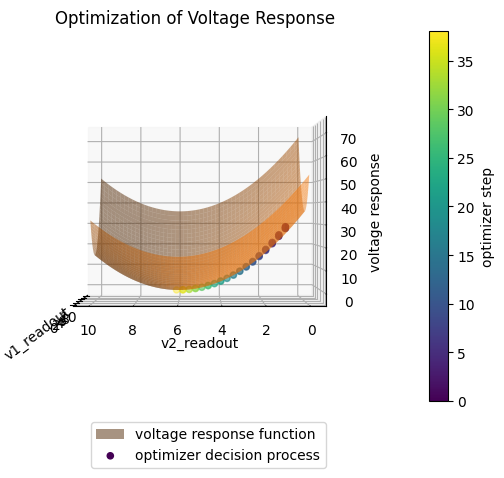

In [20]:
plot_optim_3d(0, 180)

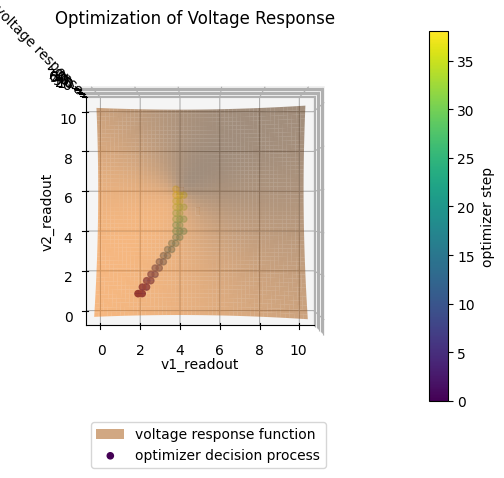

In [21]:
plot_optim_3d(90, 270)

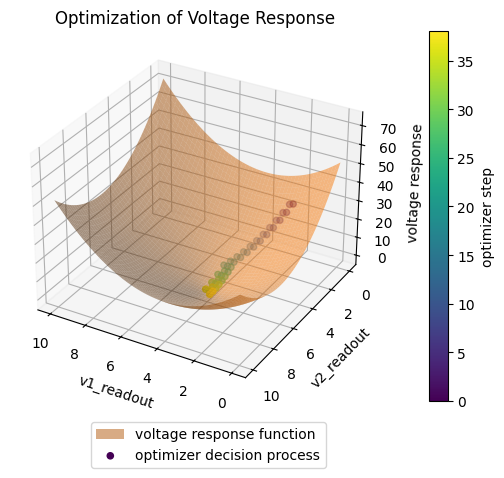

In [22]:
plot_optim_3d(30, 120)